In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from scipy.stats import halfnorm
import tensorflow as tf

%matplotlib inline

In [2]:
img_path = '/Users/calvinku/Projects/playground/patches/'
filename1 = 'image_0_2018-05-29_16_39_30_27360_9600.png'
filename2 = 'image_1_2018-07-04@B1199048-3_10560_28320.png'
filename3 = 'image_0_2018-05-10_15_21_03_21120_36480.png'
filename4 = 'image_1_2018-06-25@B1172198-6_11040_20640.png'

img_clean1 = plt.imread(img_path + filename1)
img_clean2 = plt.imread(img_path + filename2)
img_blur1 = plt.imread(img_path + filename3)
img_blur2 = plt.imread(img_path + filename4)

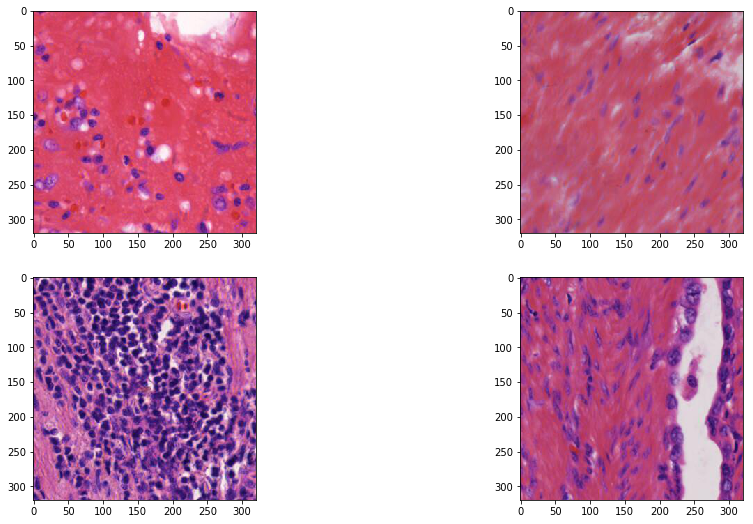

In [3]:
fig = plt.figure(figsize=(16, 9))

ax1 = fig.add_subplot(2, 2, 1)
ax1.imshow(img_clean1)

ax2 = fig.add_subplot(2, 2, 3)
ax2.imshow(img_clean2)

ax3 = fig.add_subplot(2, 2, 2)
ax3.imshow(img_blur1)

ax4 = fig.add_subplot(2, 2, 4)
ax4.imshow(img_blur2)

In [4]:
def img_to_uint8(img):
    img_normalized = (img - img.min()) / (img.max() - img.min())
    img_uint8 = (img_normalized * 255).astype(np.uint8)
    
    return img_uint8

In [5]:
img_clean1, img_clean2, img_blur1, img_blur2 = list(map(img_to_uint8, (img_clean1, img_clean2, img_blur1, img_blur2)))

In [6]:
def random_adjust_brightness(image, max_delta=0.2, seed=None):
    """Randomly adjusts brightness. """
    delta = tf.random_uniform([], -max_delta, max_delta, seed=seed)
    image = tf.image.adjust_brightness(image / 255, delta) * 255
    image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=255.0)
    return image

def random_adjust_contrast(image, min_delta=0.8, max_delta=1.25, seed=None):
    """Randomly adjusts contrast. """
    contrast_factor = tf.random_uniform([], min_delta, max_delta, seed=seed)
    image = tf.image.adjust_contrast(image / 255, contrast_factor) * 255
    image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=255.0)
    return image

def random_adjust_hue(image, max_delta=0.02, seed=None):
    """Randomly adjusts hue. """
    delta = tf.random_uniform([], -max_delta, max_delta, seed=seed)
    image = tf.image.adjust_hue(image / 255, delta) * 255
    image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=255.0)
    return image

def random_adjust_saturation(image, min_delta=0.8, max_delta=1.25, seed=None):
    """Randomly adjusts saturation. """
    saturation_factor = tf.random_uniform([], min_delta, max_delta, seed=seed)
    image = tf.image.adjust_saturation(image / 255, saturation_factor) * 255
    image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=255.0)
    return image

In [7]:
def motion_blur(img, kernel_size=13):
    # generating the kernel
    kernel_motion_blur = np.zeros((kernel_size, kernel_size))
    kernel_motion_blur[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    kernel_motion_blur = kernel_motion_blur / kernel_size

    deg = np.random.uniform(0, 180)
    kernel_motion_blur = rotate(kernel_motion_blur, deg, reshape=False)

    # applying the kernel to the input image
    output = cv2.filter2D(img, -1, kernel_motion_blur).clip(0.0, 255.0).astype(np.uint8)
    
    return output

In [8]:
img_clean1_blurred, img_clean2_blurred = list(map(motion_blur, (img_clean1, img_clean2)))

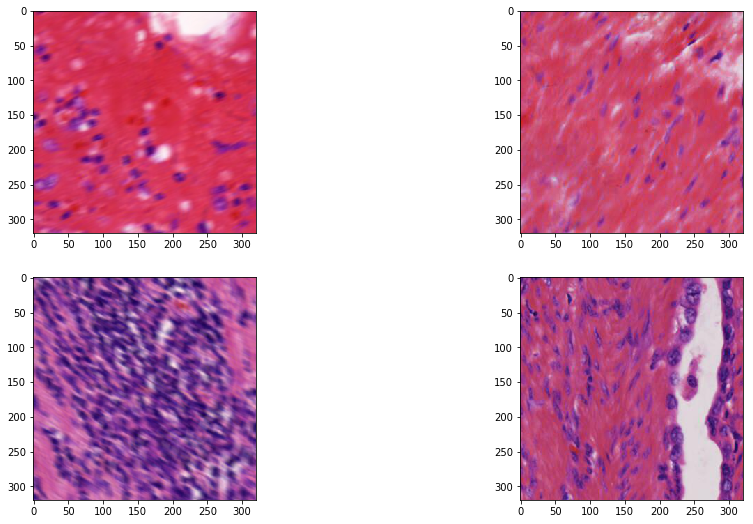

In [9]:
fig = plt.figure(figsize=(16, 9))

ax1 = fig.add_subplot(2, 2, 1)
ax1.imshow(img_to_uint8(img_clean1_blurred))

ax2 = fig.add_subplot(2, 2, 3)
ax2.imshow(img_to_uint8(img_clean2_blurred))

ax3 = fig.add_subplot(2, 2, 2)
ax3.imshow(img_blur1)

ax4 = fig.add_subplot(2, 2, 4)
ax4.imshow(img_blur2)

In [43]:
def _random_gaussian_blur(img, kernel_size=31):
    choice = np.random.choice([0, 1], replace=True, p=[0.666, 0.334])
    kernel_size = int(halfnorm.rvs(loc=kernel_size, scale=kernel_size + 1, size=1)[0])
    kernel_size = kernel_size if kernel_size % 2 else kernel_size - 1
    
    if choice:
        output = cv2.blur(img, (kernel_size, kernel_size))
    
    else:
        output = img
        
    return output.clip(0.0, 255.0)

def _random_motion_blur(img, kernel_size=31):
    choice = np.random.choice([0, 1], replace=True, p=[0.666, 0.334])
    kernel_size = int(halfnorm.rvs(loc=kernel_size, scale=kernel_size + 1, size=1)[0])
    kernel_size = kernel_size if kernel_size % 2 else kernel_size - 1
        
    if choice:
        # generating the kernel
        kernel_motion_blur = np.zeros((kernel_size, kernel_size))
        kernel_motion_blur[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
        kernel_motion_blur = kernel_motion_blur / kernel_size

        deg = np.random.uniform(0, 180)
        kernel_motion_blur_rotated = rotate(kernel_motion_blur, deg, reshape=False)
        kernel_motion_blur_rotated /= kernel_motion_blur_rotated.sum()

        # applying the kernel to the input image
        output = cv2.filter2D(img, -1, kernel_motion_blur_rotated)
    
    else:
        output = img
        
    return output.clip(0.0, 255.0)

def random_blur(img):
    def motion(img):
        return tf.py_func(_random_motion_blur, [img], tf.float32)

    def gaussian(img):
        return tf.py_func(_random_gaussian_blur, [img], tf.float32)
    
    rand_float = tf.floor(tf.random_uniform([], 0, 2))
    rand_int = tf.cast(tf.floor(rand_float), dtype=tf.int32)
    
    img = tf.cond(pred=tf.equal(rand_int, 0), true_fn=lambda: motion(img), false_fn=lambda: gaussian(img))
    
    return img

In [34]:
img = plt.imread('/Users/calvinku/Projects/playground/image_samples/gameboy.png')[:, :, :3]

In [35]:
def _img_to_255(img):
    img_max = img.max()
    img_min = img.min()
#     ratio = img_max / 255
    
    img_normalized = (img - img_min) / (img_max - img_min)
    
    img_255 = (img_normalized * 255)
    
    return img_255

In [13]:
img = _img_to_255(img)

In [14]:
img.max(), img.min()

(255.0, 0.0)

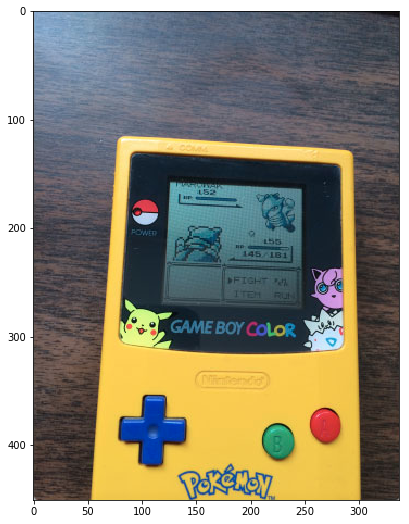

In [15]:
plt.figure(figsize=(16, 9))
plt.imshow(_random_gaussian_blur(img).astype(np.uint8))

In [16]:
img_tf = tf.convert_to_tensor(img)

255.0 0.0


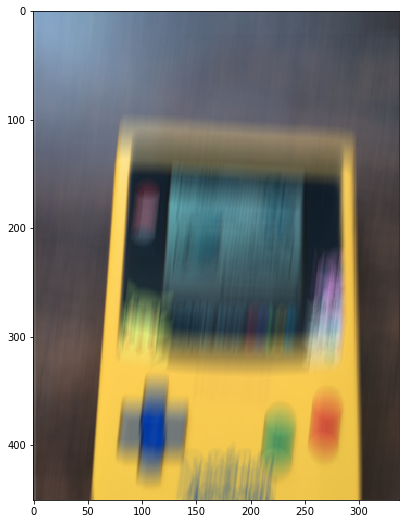

In [49]:
# img_tf_adjusted = random_adjust_brightness(img_tf, max_delta=0.25)
# img_tf_adjusted = random_adjust_contrast(img_tf, 0.5, 1.5)
# img_tf_adjusted = random_adjust_hue(img_tf, max_delta=0.02)
# img_tf_adjusted = random_adjust_saturation(img_tf, 0.5, 1.5)
img_tf_adjusted = random_blur(img_tf)

with tf.Session() as sess:
    img_tf_adjusted = sess.run(img_tf_adjusted)

print(img_tf_adjusted.max(), img_tf_adjusted.min())
plt.figure(figsize=(16, 9))
plt.imshow(img_tf_adjusted.astype(np.uint8))

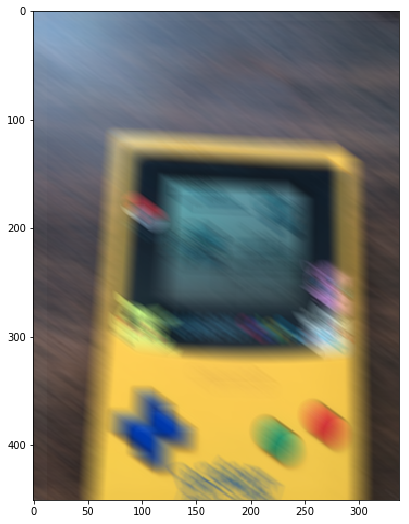

In [18]:
plt.figure(figsize=(16, 9))
plt.imshow(motion_blur(img_tf_adjusted, 31))

In [32]:
rand = tf.floor(tf.random_uniform([], 0, 2))
rand = tf.cast(tf.floor(rand), dtype=tf.int32)

result_list = []

with tf.Session() as sess:
    for _ in range(100000):
        result_list.append(sess.run(rand))
        
print(np.mean(result_list))

0.49846
